In [1]:

"""
1. generate or load data
2. train linear regression with L2 loss
3. train linear regression with adaptive loss
4. train modal linear regression
5. check bias/variance trade-off
6. (optional) plot lines
"""
from data.synthetic import data1
from model.modal_lr import ModalLinearRegression
from model.adaptive_lr import AdaptiveRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
from prettytable import PrettyTable
plt.style.use('ggplot')


In [2]:
# my_data = np.genfromtxt('faithful.csv', delimiter=',')
# data = my_data[1:,1:]
# plt.scatter(data[:,1], data[:,0])
# x, y = data[:,1], data[:,0]
# n = x.shape[0]

In [3]:
x, y = np.load('data/q3_train_X.npy'), np.load('data/q3_train_y.npy')
n = x.shape[0]

  3%|▎         | 16/500 [00:00<00:03, 152.08it/s]

Fit with the EM algorithm


100%|██████████| 1000/1000 [00:02<00:00, 340.56it/s]


{'base_model': 'linear', 'epoch': 1000, 'coef_': array([9.954487], dtype=float32), 'intercept_': 0.00735644, 'alpha': array(0.09091233, dtype=float32), 'scale': array(0.98980176, dtype=float32), 'base': RegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
), 'lr': 0.05}
+---------------------+---------+
|        Model        |   MSE   |
+---------------------+---------+
|  Linear Regression  |  76.043 |
|   Modal Regression  | 123.327 |
| Adaptive Regression | 123.078 |
+---------------------+---------+


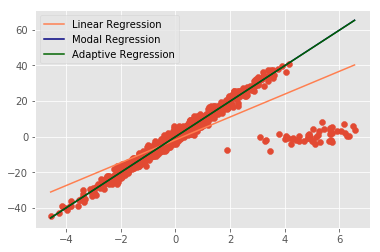

In [6]:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
# step 1
#n = cfg['data']['n']
#x, y, u = data1(n=n)
x = x.reshape(n, -1)

# step 2
lr = LinearRegression()
lr.fit(x, y)

# step 3
ml = ModalLinearRegression(bandwidth=10, maxitr=500)  # seems very important to calibrate bandwidth
ml.fit(x, y)

# step 4
ada_lr = AdaptiveRegression(lr=0.05)
ada_lr.fit(x, y)
print(ada_lr.__dict__)

# step 5
table = PrettyTable()
table.field_names = ["Model", "MSE"]
mse_lr = np.mean((y.flatten() - lr.predict(x))**2)
mse_lr = int(mse_lr * 1000) / 1000
mse_ml = np.mean((y.flatten() - ml.predict(x))**2)
mse_ml = int(mse_ml * 1000) / 1000
mse_alr = np.mean((y.flatten() - ada_lr.predict(x))**2)
mse_alr = int(mse_alr * 1000) / 1000

table.add_row(["Linear Regression", mse_lr])
table.add_row(["Modal Regression", mse_ml])
table.add_row(["Adaptive Regression", mse_alr])
print(table)

# step 6
if cfg['plot']:
    plt.scatter(x.flatten(), y)
    x_plot = np.linspace(np.min(x), np.max(x), 100)  # hacky (I know the range of X is [0,1])
    y_plot_ml = ml.predict(x_plot.reshape(100, 1))
    y_plot_alr = ada_lr.predict(x_plot.reshape(100, 1))
    y_plot_lr = lr.predict(x_plot.reshape(100, 1))
    plt.plot(x_plot, y_plot_lr, color='coral', label='Linear Regression')
    plt.plot(x_plot, y_plot_ml, color='navy', label='Modal Regression')
    plt.plot(x_plot, y_plot_alr, color='darkgreen', label='Adaptive Regression')
    plt.legend()
    # plt.savefig('fig/comparison.png')
    plt.show()


Regression clustering

In [5]:
## from https://stackoverflow.com/questions/39208679/libraries-for-regression-clustering-in-python

import numpy as np
from sklearn.linear_model import Ridge
from sklearn.base import RegressorMixin, BaseEstimator, clone

class ClusteredRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, n_components=2, base=Ridge(), random_state=1, max_iter=100, tol=1e-10, verbose=False):
        self.n_components = n_components
        self.base = base
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.estimators_ = [clone(self.base) for i in range(self.n_components)]
        # initialize cluster responsibilities randomly
        self.resp_ = np.random.uniform(size=(X.shape[0], self.n_components))
        self.resp_ /= self.resp_.sum(axis=1, keepdims=True)
        for it in range(self.max_iter):
            old_resp = self.resp_.copy()
            # Estimate sample-weithted regressions
            errors = np.empty(shape=self.resp_.shape)
            for i, est in enumerate(self.estimators_):
                est.fit(X, y, sample_weight=self.resp_[:, i])
                errors[:, i] = y - est.predict(X)
            self.mse_ = np.sum(self.resp_ * errors**2) / X.shape[0]
            if self.verbose:
                print(self.mse_)
            # Recalculate responsibilities
            self.resp_ = np.exp(-errors**2 / self.mse_)
            self.resp_ /= self.resp_.sum(axis=1, keepdims=True)
            # stop if change in responsibilites is small
            delta = np.abs(self.resp_ - old_resp).mean()
            if delta < self.tol:
                break
        self.n_iter_ = it
        return self

    def predict(self, X):
        """ Calculate a matrix of conditional predictions """
        return np.vstack([est.predict(X) for est in self.estimators_]).T

    def predict_proba(self, X, y):
        """ Estimate cluster probabilities of labeled data """
        predictions = self.predict(X)
        errors = np.empty(shape=self.resp_.shape)
        for i, est in enumerate(self.estimators_):
            errors[:, i] = y - est.predict(X)
        resp_ = np.exp(-errors**2 / self.mse_)
        resp_ /= resp_.sum(axis=1, keepdims=True)
        return resp

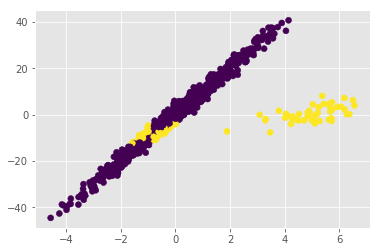

In [6]:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
x, y = np.load('data/q3_train_X.npy'), np.load('data/q3_train_y.npy')
n = x.shape[0]
model = ClusteredRegressor()
model.fit(x, y)
labels = np.argmax(model.resp_, axis=1)
plt.scatter(x, y, c=labels)
plt.show()

array([[1.00000000e+000, 2.77066727e-111],
       [1.00000000e+000, 2.08671911e-023],
       [1.00000000e+000, 6.87414346e-042],
       ...,
       [0.00000000e+000, 1.00000000e+000],
       [6.94230409e-145, 1.00000000e+000],
       [1.55500369e-316, 1.00000000e+000]])